In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기

In [3]:
weather_df_jeju = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_제주.csv")
weather_df_gosan = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_고산.csv")
weather_df_seongsan = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_성산.csv")
weather_df_seo = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_서귀포.csv")
solar_df = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/solar_energy_df.csv")

In [4]:
solar_df

date  hour  solar_energy
0      2021-01-01     1          0.00
1      2021-01-01     2          0.00
2      2021-01-01     3          0.00
3      2021-01-01     4          0.00
4      2021-01-01     5          0.01
...           ...   ...           ...
17515  2022-12-31    20          7.83
17516  2022-12-31    21          7.22
17517  2022-12-31    22          3.75
17518  2022-12-31    23          0.66
17519  2022-12-31    24          0.00

[17520 rows x 3 columns]

In [5]:
merged_df_jeju = weather_df_jeju.merge(solar_df[['date', 'hour', 'solar_energy']], on=['date', 'hour'], how='left')
merged_df_jeju

date  hour  WindDirection  WindSpeed  Cloud  Rainfall  Humidity  \
0      2021-01-01     1          320.0        6.1    9.0       0.0      53.0   
1      2021-01-01     2          320.0        5.6    9.0       0.0      58.0   
2      2021-01-01     3          320.0        5.5   10.0       0.0      54.0   
3      2021-01-01     4          320.0        5.4   10.0       0.0      52.0   
4      2021-01-01     5          290.0        4.2   10.0       0.0      47.0   
...           ...   ...            ...        ...    ...       ...       ...   
17515  2022-12-31    20          320.0        3.4    6.0       0.0      60.0   
17516  2022-12-31    21          290.0        2.9    7.0       0.0      59.0   
17517  2022-12-31    22          320.0        3.2    6.0       0.0      61.0   
17518  2022-12-31    23          250.0        1.9    3.0       0.0      62.0   
17519  2022-12-31    24          270.0        2.1    4.0       0.0      64.0   

       Temperature  Q12  Q13  Q_mean  solar_energy  
0              4.5  0.0  0.0     0.0          0.00  
1              4.3  0.0  0.0     0.0          0.00  
2              4.2  0.0  0.0     0.0          0.00  
3              4.3  0.0  0.0     0.0          0.00  
4              4.2  0.0  0.0     0.0          0.01  
...            ...  ...  ...     ...           ...  
17515          6.9  0.0  0.0     0.0          7.83  
17516          6.8  0.0  0.0     0.0          7.22  
17517          6.8  0.0  0.0     0.0          3.75  
17518          6.0  0.0  0.0     0.0          0.66  
17519          5.4  0.0  0.0     0.0          0.00  

[17520 rows x 12 columns]

In [6]:
merged_df_jeju.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 0 to 17519
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17520 non-null  object 
 1   hour           17520 non-null  int64  
 2   WindDirection  17518 non-null  float64
 3   WindSpeed      17518 non-null  float64
 4   Cloud          17502 non-null  float64
 5   Rainfall       17520 non-null  float64
 6   Humidity       17520 non-null  float64
 7   Temperature    17520 non-null  float64
 8   Q12            17520 non-null  float64
 9   Q13            17520 non-null  float64
 10  Q_mean         17520 non-null  float64
 11  solar_energy   17491 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.7+ MB


In [7]:
merged_df_jeju = merged_df_jeju.dropna()

<ipython-input-8-a4742e4d20a3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df_jeju.corr(), annot=True, cmap=cmap)


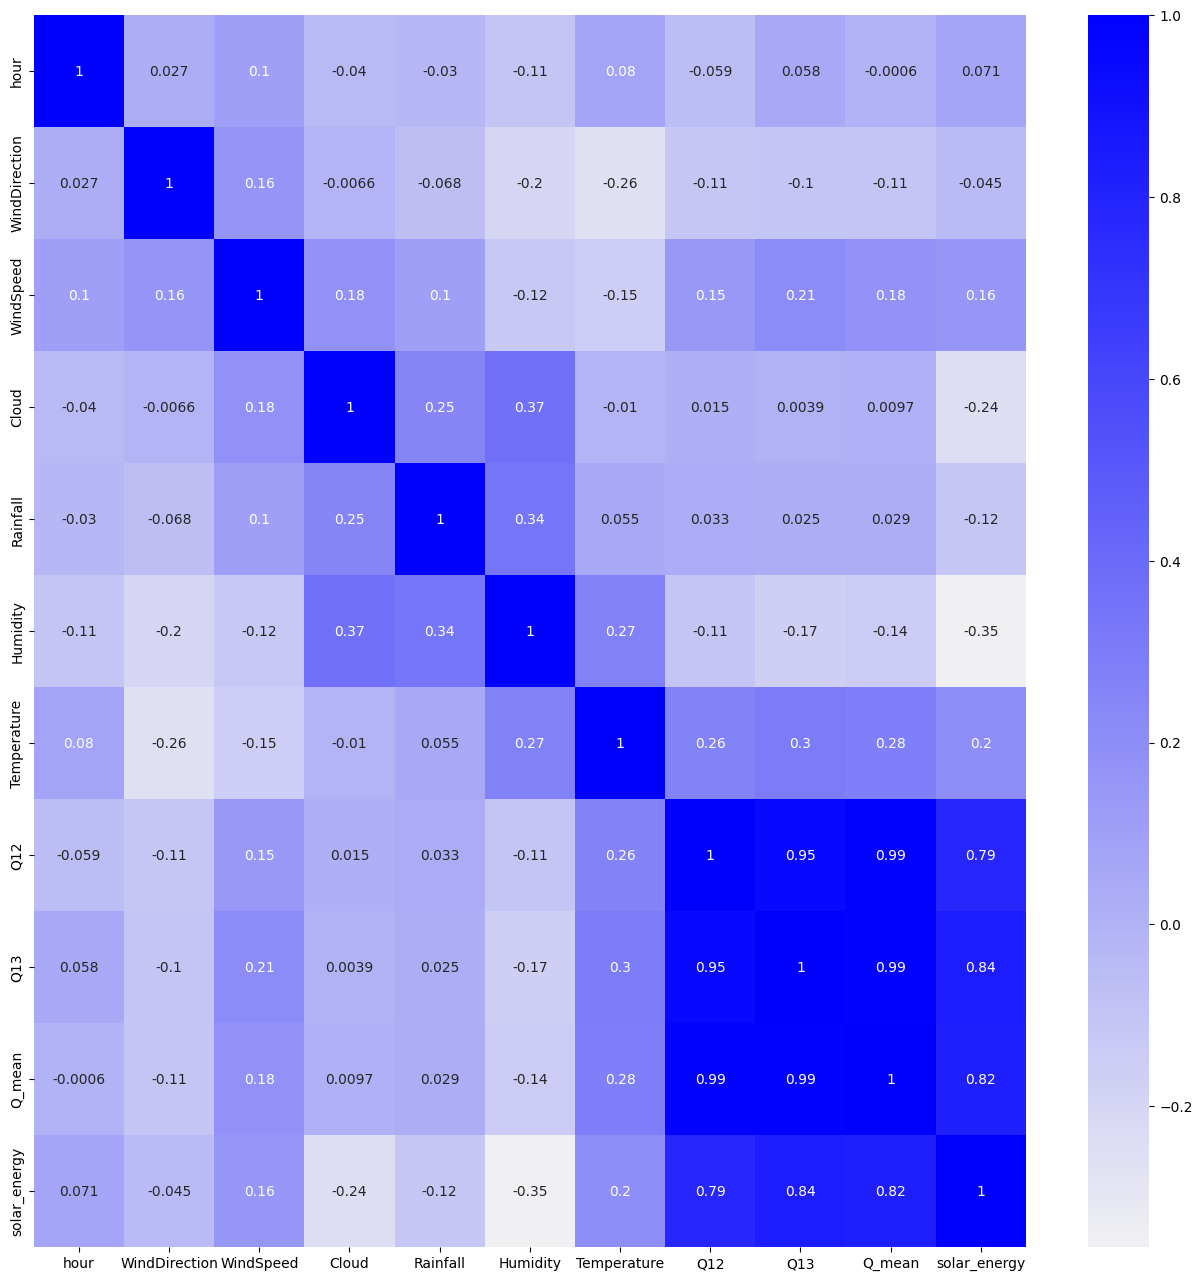

In [8]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette(color="b", as_cmap=True)
sns.heatmap(merged_df_jeju.corr(), annot=True, cmap=cmap)
plt.show()

# 모델링

In [9]:
import os
from tqdm import tqdm
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [10]:
# z - score scaling
ss = StandardScaler()

# 'solar_energy'(y)는 안했음
columns_to_scale = ['WindDirection', 'WindSpeed', 'Cloud', 'Rainfall', 'Humidity', 'Temperature', 'Q12', 'Q13', 'Q_mean']
merged_df_jeju[columns_to_scale] = ss.fit_transform(merged_df_jeju[columns_to_scale])

<ipython-input-10-ec9f24479957>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_jeju[columns_to_scale] = ss.fit_transform(merged_df_jeju[columns_to_scale])


In [11]:
# features 우선 마음대로 해봄
features = merged_df_jeju.drop(['date', 'WindDirection', 'WindSpeed', 'Q12', 'Q_mean', 'solar_energy'], axis=1)
labels = merged_df_jeju['solar_energy']

In [12]:
class SunlightDataset(Dataset):
    def __init__(self, features, labels, window_size=2, step_size=1):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        total_steps = len(self.features) - self.window_size + 1
        # Calculate the number of complete windows that can be formed
        if total_steps > 0:
            return (total_steps + self.step_size - 1) // self.step_size
        else:
            return 0

    def __getitem__(self, index):
        start = index * self.step_size
        end = start + self.window_size

        return (self.features[start:end], self.labels[start:end])

In [13]:
col_name = list(features.columns)

In [14]:
col_name

['hour', 'Cloud', 'Rainfall', 'Humidity', 'Temperature', 'Q13']

In [15]:
features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [16]:
train_dataset = SunlightDataset(features_train, labels_train)
val_dataset = SunlightDataset(features_val, labels_val)

In [17]:
len(train_dataset), len(val_dataset)

(13975, 3494)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [19]:
print(train_dataset[0])
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

(tensor([[11.0000,  0.8053, -0.2429, -0.1263,  1.5072,  1.6152],
        [ 4.0000, -1.1678, -0.2429,  0.1485, -2.0403, -0.8091]]), tensor([98.5500,  0.7500]))
torch.Size([2, 6])
torch.Size([2])


In [20]:
train_features, train_labels = next(iter(train_loader))
print(train_features.shape)
print(train_labels.shape)

torch.Size([64, 2, 6])
torch.Size([64, 2])


In [21]:
!pip install transformers

In [22]:
import torch
import torch.nn as nn

try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel

In [23]:
class LSTMwithAttn(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads=8, dropout=0.1, device='cpu'):
        super(LSTMwithAttn, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout
        self.device = device

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.config = BertConfig(
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
        )
        self.encoder = BertEncoder(self.config)

        self.act = nn.SiLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()


    def init_hidden_state(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        return (h0, c0)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def generate_attn_mask(self, x):
        seq_len = x.size(1)
        attn_mask = torch.tril(torch.ones((seq_len, seq_len))).view(1, seq_len, seq_len).to(self.device)

        return attn_mask


    def forward(self, x):
        batch_size = x.size(0)

        h0, c0 = self.init_hidden_state(batch_size)

        output, (hidden, cell) = self.lstm(x, (h0, c0))

        output = output.contiguous().view(batch_size, -1, self.hidden_dim)

        # Attention Mask
        attn_mask = self.generate_attn_mask(x)
        extended_attn_mask = attn_mask[None, :, :, :].expand(batch_size, -1, -1, -1)
        extended_attn_mask = (1.0 - extended_attn_mask) * -10000.0

        encoder_outputs = self.encoder(output, attention_mask=extended_attn_mask)

        output = self.act(encoder_outputs.last_hidden_state)
        output = self.fc(output)

        return output

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
model = LSTMwithAttn(input_dim=6, hidden_dim=64, output_dim=1, num_layers=2, device=device)

In [26]:
model = model.to(device)

In [27]:
LEARNING_RATE = 0.001
EPOCHS = 100
WEIGHT_DECAY = 0.01
EARLY_STOPPING = 5

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [29]:
criterion = nn.MSELoss(reduction='mean')

In [30]:
train_losses = []
val_losses = []

loss = .0
best_val_loss = float('inf')
increasing_loss_count = 0

In [31]:
model.eval()

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)

        loss += _loss.item()

print(f'Initial Loss: {loss/len(val_loader):.4f}')

Initial Loss: 5847.1552


In [32]:
train_losses = []
val_losses = []

for i in range(EPOCHS):
    print("=" * 30)
    print(f"Current Epoch {i+1}")
    print("=" * 30)
    print("Training...")
    train_loss = .0

    model.train()
    for features, labels in tqdm(train_loader, leave=False):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)
        _loss.backward()
        optimizer.step()

        train_loss += _loss.item()


    print("Evaluating...")
    val_loss = .0

    model.eval()

    for features, labels in tqdm(val_loader, leave=False):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)

        val_loss += _loss.item()

    train_losses += [train_loss/len(train_loader)]
    epoch_val_loss = val_loss/len(val_loader)
    val_losses += [epoch_val_loss]
    print(f"Epoch #{i+1}: [Training MSE/Evaluation MSE]: [{train_loss/len(train_loader):.4f}/{val_loss/len(val_loader):.4f}]")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    if increasing_loss_count >= EARLY_STOPPING:
        print("Early Stopping!")
        break

Current Epoch 1
Training...


Evaluating...


Epoch #1: [Training MSE/Evaluation MSE]: [5329.7931/4506.4590]
Current Epoch 2
Training...


Evaluating...


Epoch #2: [Training MSE/Evaluation MSE]: [4033.3533/3052.9078]
Current Epoch 3
Training...


Evaluating...


Epoch #3: [Training MSE/Evaluation MSE]: [2656.0612/1944.2693]
Current Epoch 4
Training...


Evaluating...


Epoch #4: [Training MSE/Evaluation MSE]: [1701.2997/1222.8325]
Current Epoch 5
Training...


Evaluating...


Epoch #5: [Training MSE/Evaluation MSE]: [1100.7184/776.8247]
Current Epoch 6
Training...


Evaluating...


Epoch #6: [Training MSE/Evaluation MSE]: [768.6941/559.0806]
Current Epoch 7
Training...


Evaluating...


Epoch #7: [Training MSE/Evaluation MSE]: [580.3854/448.5360]
Current Epoch 8
Training...


Evaluating...


Epoch #8: [Training MSE/Evaluation MSE]: [490.6838/397.3975]
Current Epoch 9
Training...


Evaluating...


Epoch #9: [Training MSE/Evaluation MSE]: [441.9747/364.2093]
Current Epoch 10
Training...


Evaluating...


Epoch #10: [Training MSE/Evaluation MSE]: [411.3768/349.3233]
Current Epoch 11
Training...


Evaluating...


Epoch #11: [Training MSE/Evaluation MSE]: [393.1943/339.7168]
Current Epoch 12
Training...


Evaluating...


Epoch #12: [Training MSE/Evaluation MSE]: [381.3971/336.4127]
Current Epoch 13
Training...


Evaluating...


Epoch #13: [Training MSE/Evaluation MSE]: [370.5634/334.3356]
Current Epoch 14
Training...


Evaluating...


Epoch #14: [Training MSE/Evaluation MSE]: [362.0150/329.2586]
Current Epoch 15
Training...


Evaluating...


Epoch #15: [Training MSE/Evaluation MSE]: [356.7889/328.2432]
Current Epoch 16
Training...


Evaluating...


Epoch #16: [Training MSE/Evaluation MSE]: [351.4210/319.5695]
Current Epoch 17
Training...


Evaluating...


Epoch #17: [Training MSE/Evaluation MSE]: [345.9752/316.4942]
Current Epoch 18
Training...


Evaluating...


Epoch #18: [Training MSE/Evaluation MSE]: [342.2225/317.1539]
Current Epoch 19
Training...


Evaluating...


Epoch #19: [Training MSE/Evaluation MSE]: [338.4871/316.8003]
Current Epoch 20
Training...


Evaluating...


Epoch #20: [Training MSE/Evaluation MSE]: [335.8803/315.9309]
Current Epoch 21
Training...


Evaluating...


Epoch #21: [Training MSE/Evaluation MSE]: [333.8899/312.7475]
Current Epoch 22
Training...


Evaluating...


Epoch #22: [Training MSE/Evaluation MSE]: [330.2133/312.6899]
Current Epoch 23
Training...


Evaluating...


Epoch #23: [Training MSE/Evaluation MSE]: [328.6435/311.5018]
Current Epoch 24
Training...


Evaluating...


Epoch #24: [Training MSE/Evaluation MSE]: [327.4360/312.3206]
Current Epoch 25
Training...


Evaluating...


Epoch #25: [Training MSE/Evaluation MSE]: [324.4948/313.2661]
Current Epoch 26
Training...


Evaluating...


Epoch #26: [Training MSE/Evaluation MSE]: [323.0499/312.9918]
Current Epoch 27
Training...


Evaluating...


Epoch #27: [Training MSE/Evaluation MSE]: [320.6191/313.6746]
Current Epoch 28
Training...


Evaluating...


Epoch #28: [Training MSE/Evaluation MSE]: [319.9278/312.9625]
Early Stopping!


In [33]:
%matplotlib inline

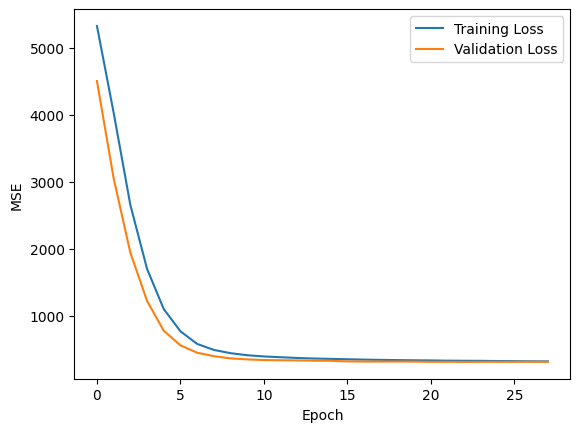

In [34]:
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [35]:
directory = 'models'
os.makedirs(directory, exist_ok=True)

torch.save(model.state_dict(), 'models/model.pt')

# 내일 데이터 불러오기

In [79]:
import pandas as pd
import urllib
import urllib.request
import json

In [ ]:
from datetime import date, timedelta
#오늘 날짜 불러오기
today = date.today()
formatted_today = today.strftime('%Y%m%d')
tomorrow = today + timedelta(days=1)
formatted_tomorrow = tomorrow.strftime('%Y%m%d')

In [80]:
servicekey = 's+fQ9LDUrt9xJ9LSIp0R4+gJBR7eOiUpRHNKXMb6gaV844FL4oI+OYVOY+MC2Bff+Iq9bQWFeWrktswAfBtkyg=='
url= 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst'

queryParams = '?' + urllib.parse.urlencode(
    {
        urllib.parse.quote_plus('servicekey') : servicekey,
        urllib.parse.quote_plus('pageNo') : '1',
        urllib.parse.quote_plus('numOfRows') : '372',  # 12 * 31 = 372
       # 아님 12개 항목임
        urllib.parse.quote_plus('dataType') : 'JSON', # JSON, XML 두가지 포멧을 제공합니다.
        urllib.parse.quote_plus('base_date') : formatted_today, # 예보 받을 날짜를 입력합니다. 최근 1일간의 자료만 제공합니다.
        urllib.parse.quote_plus('base_time') : '1700', # 예보 시간을 입력합니다. 2시부터 시작하여 3시간 단위로 입력 가능합니다.
        urllib.parse.quote_plus('nx') : '48', # 울산 태양광 발전소 x 좌표입니다. '기상청18_동네예보 조회서비스_오픈API활용가이드.zip'에 포함 된 excel파일을 통해 확인 가능합니다.
        urllib.parse.quote_plus('ny') : '36' # 울산 태양광 발전소 y 좌표입니다. '기상청18_동네예보 조회서비스_오픈API활용가이드.zip'에 포함 된 excel파일을 통해 확인 가능합니다.
    }
)

response = urllib.request.urlopen(url + queryParams).read()
response = json.loads(response)

In [81]:
import pandas as pd

# 새로운 데이터프레임을 생성
fcst_df = pd.DataFrame(columns=['Forecast_date', 'Forecast_hour', 'WindDirection', 'WindSpeed', 'Cloud', 'Rainfall', 'Humidity', 'Temperature'])

row_idx = 0  # row_idx 초기화

for data in response['response']['body']['items']['item']:
    fcst_df.loc[row_idx, 'Forecast_date'] = data['fcstDate']
    fcst_df.loc[row_idx, 'Forecast_hour'] = data['fcstTime']

    if data['category'] == 'REH':
        fcst_df.loc[row_idx, 'Humidity'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'PCP':
        fcst_df.loc[row_idx, 'Rainfall'] = str(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'TMP':
        fcst_df.loc[row_idx, 'Temperature'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'SKY':
        fcst_df.loc[row_idx, 'Cloud'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'VEC':
        fcst_df.loc[row_idx, 'WindDirection'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'WSD':
        fcst_df.loc[row_idx, 'WindSpeed'] = float(data.get('fcstValue', 'NaN'))
        row_idx += 1  # 다음 행으로 이동

# train data와 양식 맞추기

In [82]:
# Forecast_date와 Forecast_hour 열을 datetime 형식으로 변환
fcst_df['Forecast_date'] = pd.to_datetime(fcst_df['Forecast_date'], format='%Y%m%d')
fcst_df['Forecast_hour'] = fcst_df['Forecast_hour'].astype(str).str.zfill(4)  # 시간을 4자리 문자열로 변환
fcst_df['Forecast_hour'] = fcst_df['Forecast_hour'].str[:2].astype(int)  # 앞의 2자리를 추출하여 정수로 변환

In [83]:
fcst_df = fcst_df.rename(columns={'Forecast_date': 'date', 'Forecast_hour': 'hour'})

# date가 '
# 내일 날짜인 데이터만 추출하여 tomorrow_df에 저장
tomorrow_df = fcst_df[(fcst_df['date'] == formatted_tomorrow)].copy()

In [84]:
tomorrow_df.replace('강수없음', int('0'), inplace=True)

In [85]:
tomorrow_df

date  hour  WindDirection  WindSpeed  Cloud Rainfall  Humidity  \
6  2024-02-14     0          166.0        5.4    4.0        0      80.0   
7  2024-02-14     1          170.0        5.4    4.0        0      80.0   
8  2024-02-14     2          175.0        5.7    4.0        0      80.0   
9  2024-02-14     3          174.0        5.4    4.0        0      80.0   
10 2024-02-14     4          177.0        5.3    4.0        0      80.0   
11 2024-02-14     5          182.0        4.9    4.0        0      80.0   
12 2024-02-14     6          180.0        4.9    4.0        0      85.0   
13 2024-02-14     7          190.0        4.8    4.0        0      85.0   
14 2024-02-14     8          202.0        4.0    4.0   1mm 미만      90.0   
15 2024-02-14     9          188.0        3.4    4.0   1mm 미만      90.0   
16 2024-02-14    10          196.0        4.4    4.0    1.0mm      90.0   
17 2024-02-14    11          194.0        5.0    4.0    2.0mm      90.0   
18 2024-02-14    12          185.0        4.7    4.0    2.0mm      85.0   
19 2024-02-14    13          183.0        4.1    4.0    3.0mm      85.0   
20 2024-02-14    14          190.0        4.0    4.0    2.0mm      80.0   
21 2024-02-14    15          187.0        3.9    4.0   1mm 미만      80.0   
22 2024-02-14    16          180.0        3.4    4.0   1mm 미만      80.0   
23 2024-02-14    17          178.0        2.9    4.0   1mm 미만      85.0   
24 2024-02-14    18          177.0        2.0    4.0   1mm 미만      85.0   
25 2024-02-14    19          161.0        1.8    4.0        0      90.0   
26 2024-02-14    20          155.0        1.9    4.0        0      90.0   
27 2024-02-14    21          151.0        1.8    4.0        0      90.0   
28 2024-02-14    22          157.0        2.1    4.0        0      95.0   
29 2024-02-14    23          164.0        2.2    4.0        0      95.0   

    Temperature  
6          14.0  
7          15.0  
8          16.0  
9          16.0  
10         16.0  
11         16.0  
12         16.0  
13         15.0  
14         15.0  
15         16.0  
16         16.0  
17         16.0  
18         17.0  
19         17.0  
20         18.0  
21         17.0  
22         17.0  
23         17.0  
24         16.0  
25         16.0  
26         15.0  
27         15.0  
28         15.0  
29         15.0

In [86]:
# Rainfall 열 값 변경
rainfall_mapping = {'0': 0, '1mm 미만': 1, '1.0mm': 1, '2.0mm': 1, '3.0mm': 1}
tomorrow_df['Rainfall'] = tomorrow_df['Rainfall'].astype(str).map(rainfall_mapping).fillna(2).astype(int)

# Cloud 값 보정
cloud_mapping = {1: 2, 2: 4, 3: 8, 4: 10}
tomorrow_df['Cloud'] = tomorrow_df['Cloud'].map(cloud_mapping)

# hour 값 0~23 을 1~24로 수정
tomorrow_df['hour'] = tomorrow_df['hour'] + 1

tomorrow_df

date  hour  WindDirection  WindSpeed  Cloud  Rainfall  Humidity  \
6  2024-02-14     1          166.0        5.4     10         0      80.0   
7  2024-02-14     2          170.0        5.4     10         0      80.0   
8  2024-02-14     3          175.0        5.7     10         0      80.0   
9  2024-02-14     4          174.0        5.4     10         0      80.0   
10 2024-02-14     5          177.0        5.3     10         0      80.0   
11 2024-02-14     6          182.0        4.9     10         0      80.0   
12 2024-02-14     7          180.0        4.9     10         0      85.0   
13 2024-02-14     8          190.0        4.8     10         0      85.0   
14 2024-02-14     9          202.0        4.0     10         1      90.0   
15 2024-02-14    10          188.0        3.4     10         1      90.0   
16 2024-02-14    11          196.0        4.4     10         1      90.0   
17 2024-02-14    12          194.0        5.0     10         1      90.0   
18 2024-02-14    13          185.0        4.7     10         1      85.0   
19 2024-02-14    14          183.0        4.1     10         1      85.0   
20 2024-02-14    15          190.0        4.0     10         1      80.0   
21 2024-02-14    16          187.0        3.9     10         1      80.0   
22 2024-02-14    17          180.0        3.4     10         1      80.0   
23 2024-02-14    18          178.0        2.9     10         1      85.0   
24 2024-02-14    19          177.0        2.0     10         1      85.0   
25 2024-02-14    20          161.0        1.8     10         0      90.0   
26 2024-02-14    21          155.0        1.9     10         0      90.0   
27 2024-02-14    22          151.0        1.8     10         0      90.0   
28 2024-02-14    23          157.0        2.1     10         0      95.0   
29 2024-02-14    24          164.0        2.2     10         0      95.0   

    Temperature  
6          14.0  
7          15.0  
8          16.0  
9          16.0  
10         16.0  
11         16.0  
12         16.0  
13         15.0  
14         15.0  
15         16.0  
16         16.0  
17         16.0  
18         17.0  
19         17.0  
20         18.0  
21         17.0  
22         17.0  
23         17.0  
24         16.0  
25         16.0  
26         15.0  
27         15.0  
28         15.0  
29         15.0

In [87]:
an = [1.000110,0.034221,0.000719]
bn = [0,0.001280,0.000077]
cn = [0.006918,-0.399912,-0.006758,-0.002697]
dn = [0,0.070257,0.000907,0.000148]


S = 1367 #solar constant
L = 33.3 #latitude
L_rad = np.deg2rad(L) #latitude를 rad으로 변환

tomorrow_df['date'] = pd.to_datetime(tomorrow_df['date'])
d = tomorrow_df['date'].dt.dayofyear
t = 2*np.pi*d/365

In [88]:
LN = datetime.datetime(2024, 2, 9, 12, 0, 0) # local noon time

In [89]:
# sun-earth distance  : r0 값을 알 수 없어서, a로 근사한 식을 이용함
r0_r2 = np.zeros(t.shape)
for i in range(0,3) :
    r0_r2 = r0_r2+an[i]*np.cos(i*t)+bn[i]*np.sin(i*t)

# declination angle
delta_rad = np.zeros(t.shape)
for i in range(0,4) :
    delta_rad = delta_rad+cn[i]*np.cos(i*t)+dn[i]*np.sin(i*t)

In [90]:
# Solar insolation for hour gap
# Q12는 태양 남중 12시로 가정한거고, Q13은 남중 13시로 가정한검니당
Q = np.zeros(t.shape)
gap = np.pi/12
tomorrow_df['Q12'] = S*r0_r2*((np.sin(L_rad)*np.sin(delta_rad))+((24/np.pi)*np.cos(L_rad)*np.cos(delta_rad)*np.sin(np.pi/24)*np.cos((tomorrow_df.hour-12)*gap)))
tomorrow_df['Q12'] = tomorrow_df['Q12'].apply(lambda x: max(0, x))
tomorrow_df['Q13'] = S*r0_r2*((np.sin(L_rad)*np.sin(delta_rad))+((24/np.pi)*np.cos(L_rad)*np.cos(delta_rad)*np.sin(np.pi/24)*np.cos((tomorrow_df.hour-13)*gap)))
tomorrow_df['Q13'] = tomorrow_df['Q13'].apply(lambda x: max(0, x))
tomorrow_df['Q_mean'] = (tomorrow_df['Q12']+tomorrow_df['Q13'])/2

In [91]:
tomorrow_df

date  hour  WindDirection  WindSpeed  Cloud  Rainfall  Humidity  \
6  2024-02-14     1          166.0        5.4     10         0      80.0   
7  2024-02-14     2          170.0        5.4     10         0      80.0   
8  2024-02-14     3          175.0        5.7     10         0      80.0   
9  2024-02-14     4          174.0        5.4     10         0      80.0   
10 2024-02-14     5          177.0        5.3     10         0      80.0   
11 2024-02-14     6          182.0        4.9     10         0      80.0   
12 2024-02-14     7          180.0        4.9     10         0      85.0   
13 2024-02-14     8          190.0        4.8     10         0      85.0   
14 2024-02-14     9          202.0        4.0     10         1      90.0   
15 2024-02-14    10          188.0        3.4     10         1      90.0   
16 2024-02-14    11          196.0        4.4     10         1      90.0   
17 2024-02-14    12          194.0        5.0     10         1      90.0   
18 2024-02-14    13          185.0        4.7     10         1      85.0   
19 2024-02-14    14          183.0        4.1     10         1      85.0   
20 2024-02-14    15          190.0        4.0     10         1      80.0   
21 2024-02-14    16          187.0        3.9     10         1      80.0   
22 2024-02-14    17          180.0        3.4     10         1      80.0   
23 2024-02-14    18          178.0        2.9     10         1      85.0   
24 2024-02-14    19          177.0        2.0     10         1      85.0   
25 2024-02-14    20          161.0        1.8     10         0      90.0   
26 2024-02-14    21          155.0        1.9     10         0      90.0   
27 2024-02-14    22          151.0        1.8     10         0      90.0   
28 2024-02-14    23          157.0        2.1     10         0      95.0   
29 2024-02-14    24          164.0        2.2     10         0      95.0   

    Temperature         Q12         Q13      Q_mean  
6          14.0    0.000000    0.000000    0.000000  
7          15.0    0.000000    0.000000    0.000000  
8          16.0    0.000000    0.000000    0.000000  
9          16.0    0.000000    0.000000    0.000000  
10         16.0    0.000000    0.000000    0.000000  
11         16.0    0.000000    0.000000    0.000000  
12         16.0  121.396463    0.000000   60.698232  
13         15.0  395.961630  121.396463  258.679047  
14         15.0  631.736084  395.961630  513.848857  
15         16.0  812.652185  631.736084  722.194135  
16         16.0  926.380801  812.652185  869.516493  
17         16.0  965.171514  926.380801  945.776158  
18         17.0  926.380801  965.171514  945.776158  
19         17.0  812.652185  926.380801  869.516493  
20         18.0  631.736084  812.652185  722.194135  
21         17.0  395.961630  631.736084  513.848857  
22         17.0  121.396463  395.961630  258.679047  
23         17.0    0.000000  121.396463   60.698232  
24         16.0    0.000000    0.000000    0.000000  
25         16.0    0.000000    0.000000    0.000000  
26         15.0    0.000000    0.000000    0.000000  
27         15.0    0.000000    0.000000    0.000000  
28         15.0    0.000000    0.000000    0.000000  
29         15.0    0.000000    0.000000    0.000000

In [92]:
# columns_to_scale 정의
columns_to_scale = ['WindDirection', 'WindSpeed', 'Cloud', 'Rainfall', 'Humidity', 'Temperature', 'Q12', 'Q13', 'Q_mean']

# test 세트에도 동일한 scaling 적용
tomorrow_df[columns_to_scale] = ss.transform(tomorrow_df[columns_to_scale])

In [93]:
tomorrow_df.describe()

hour  WindDirection  WindSpeed      Cloud   Rainfall   Humidity  \
count  24.000000      24.000000  24.000000  24.000000  24.000000  24.000000   
mean   12.500000      -0.024260   0.300901   1.087224   1.197989   1.001528   
std     7.071068       0.119030   0.724370   0.000000   1.600129   0.349678   
min     1.000000      -0.260168  -0.834213   1.087224  -0.242925   0.629392   
25%     6.750000      -0.100431  -0.332230   1.087224  -0.242925   0.629392   
50%    12.500000      -0.011688   0.386826   1.087224  -0.242925   0.972902   
75%    18.250000       0.061525   0.861674   1.087224   2.900887   1.316412   
max    24.000000       0.192420   1.282254   1.087224   2.900887   1.659922   

       Temperature        Q12        Q13     Q_mean  
count    24.000000  24.000000  24.000000  24.000000  
mean     -0.167323  -0.169219  -0.169166  -0.171363  
std       0.112816   0.851921   0.851965   0.849840  
min      -0.400177  -0.809135  -0.809115  -0.819508  
25%      -0.278688  -0.809135  -0.809115  -0.819508  
50%      -0.157199  -0.809135  -0.809115  -0.749479  
75%      -0.126827   0.630055   0.630150   0.486356  
max       0.085780   1.389671   1.389805   1.362818

In [94]:
testdata = tomorrow_df.drop(['date', 'WindDirection', 'WindSpeed', 'Q12', 'Q_mean'], axis=1)

# 다음날 값 예측

In [95]:
# Load the model

model.load_state_dict( torch.load('models/model.pt') )
model.to(device)

LSTMwithAttn(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-1): 2 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=64, out_features=64, bias=True)
            (key): Linear(in_features=64, out_features=64, bias=True)
            (value): Linear(in_features=64, out_features=64, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=64, out_features=64, bias=True)
            (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=

In [96]:
testdata

hour     Cloud  Rainfall  Humidity  Temperature       Q13
6      1  1.087224 -0.242925  0.629392    -0.400177 -0.809115
7      2  1.087224 -0.242925  0.629392    -0.278688 -0.809115
8      3  1.087224 -0.242925  0.629392    -0.157199 -0.809115
9      4  1.087224 -0.242925  0.629392    -0.157199 -0.809115
10     5  1.087224 -0.242925  0.629392    -0.157199 -0.809115
11     6  1.087224 -0.242925  0.629392    -0.157199 -0.809115
12     7  1.087224 -0.242925  0.972902    -0.157199 -0.809115
13     8  1.087224 -0.242925  0.972902    -0.278688 -0.532541
14     9  1.087224  2.900887  1.316412    -0.278688  0.092992
15    10  1.087224  2.900887  1.316412    -0.157199  0.630150
16    11  1.087224  2.900887  1.316412    -0.157199  1.042325
17    12  1.087224  2.900887  1.316412    -0.157199  1.301430
18    13  1.087224  2.900887  0.972902    -0.035710  1.389805
19    14  1.087224  2.900887  0.972902    -0.035710  1.301430
20    15  1.087224  2.900887  0.629392     0.085780  1.042325
21    16  1.087224  2.900887  0.629392    -0.035710  0.630150
22    17  1.087224  2.900887  0.629392    -0.035710  0.092992
23    18  1.087224  2.900887  0.972902    -0.035710 -0.532541
24    19  1.087224  2.900887  0.972902    -0.157199 -0.809115
25    20  1.087224 -0.242925  1.316412    -0.157199 -0.809115
26    21  1.087224 -0.242925  1.316412    -0.278688 -0.809115
27    22  1.087224 -0.242925  1.316412    -0.278688 -0.809115
28    23  1.087224 -0.242925  1.659922    -0.278688 -0.809115
29    24  1.087224 -0.242925  1.659922    -0.278688 -0.809115

In [97]:
features_test = testdata
labels_test = pd.DataFrame({'label': [0] * len(testdata)})
test_dataset = SunlightDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [98]:
# get number of rows in testdata
num_test = len(features_test)
num_test

24

In [99]:
next(iter(test_loader))[0].shape

torch.Size([1, 2, 6])

In [100]:
y_pred = [[] for _ in range(num_test)]
len(y_pred)

24

In [101]:
# test phase
model.eval()

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features).squeeze(-1)
        outputs[outputs < 3] = 0

        for seq_idx in range(outputs.shape[-1]):
            y_pred[i + seq_idx].append(outputs[:,seq_idx].item())

In [102]:
y_pred = [sum(y_pred[i]) / len(y_pred[i]) for i in range(len(y_pred))]

In [103]:
y_pred

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.045437812805176,
 16.341073513031006,
 31.13196849822998,
 41.91213417053223,
 46.36685562133789,
 46.38149070739746,
 44.9498233795166,
 38.99345016479492,
 29.749364852905273,
 14.885826587677002,
 4.291096210479736,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [104]:
y_pred_pd = pd.DataFrame(y_pred)
y_pred_pd.to_csv('solar.csv', index=False)

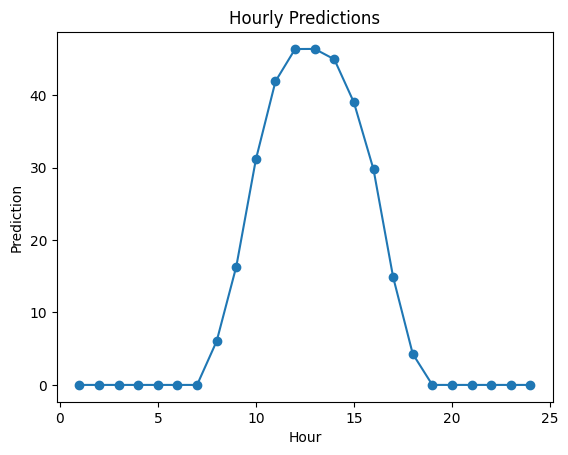

In [107]:
plt.plot(range(1, 25), y_pred_pd[0], marker='o')
plt.xlabel('Hour')
plt.ylabel('Prediction')
plt.title('Hourly Predictions')
plt.savefig('Tomorrow_Solar_Energy(hourly).png')
plt.show()